# Homework 4 – Clustering MNIST with Multiple Distance Metrics
Author: Selim Aynigül – 200104004004
Date: 2025‑05‑13


This notebook completes **Homework 4**.  
Key points implemented exactly as required:

* **Data**: MNIST 784, reduced with **PCA (50 dims)** – **fit _only on the training fold_** to avoid leakage.  
* **Clustering**: custom **k‑means (k = 10)** supporting **Euclidean (L2), Manhattan (L1) and Cosine** with metric‑specific *k‑means++* initialisation and `n_init=10`.  
* **Labeling clusters**: greedy maximum \(n_{i,j}\) rule.  
* **Training error**: confusion matrix & accuracy (per fold + mean ± std).  
* **Test error**: assign each test sample to the cluster of its **1‑nearest‑neighbour** (metric‑consistent) from the training set; compute confusion & accuracy.  
* **Visualisation**: heat‑maps of the average training / test confusion matrices.  
* **Conclusions**: summary of results is auto‑generated after evaluation.


In [5]:

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import seaborn as sns

# for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [6]:

# ------------------------------------------------------------
# Distance helpers
# ------------------------------------------------------------
def pairwise_distance(a, b, metric="euclidean"):
    """Compute pairwise distance between two 2‑D arrays.

    Parameters
    ----------
    a, b : ndarray of shape (n_samples_a, n_features) / (n_samples_b, n_features)
    metric : {'euclidean', 'manhattan', 'cosine'}
    """
    if metric == "euclidean":
        dists = np.linalg.norm(a[:, None] - b[None, :], axis=-1)
    elif metric == "manhattan":
        dists = np.abs(a[:, None] - b[None, :]).sum(axis=-1)
    elif metric == "cosine":
        # cosine distance = 1 - cosine similarity
        a_norm = normalize(a)
        b_norm = normalize(b)
        dists = 1 - np.dot(a_norm, b_norm.T)
    else:
        raise ValueError(f"Unknown metric: {metric}")
    return dists

# ------------------------------------------------------------
# k‑means with metric‑specific k‑means++ initialisation
# ------------------------------------------------------------
def _init_centroids_kpp(X, k, metric, rs):
    """k‑means++ initialisation for arbitrary metric."""
    n_samples = X.shape[0]
    centroids = np.empty((k, X.shape[1]), dtype=X.dtype)
    # choose first centroid randomly
    first_idx = rs.randint(n_samples)
    centroids[0] = X[first_idx]
    # choose remaining
    for ci in range(1, k):
        dists = pairwise_distance(X, centroids[:ci], metric).min(axis=1)
        probs = dists ** 2
        probs_sum = probs.sum()
        if probs_sum == 0:
            next_idx = rs.randint(n_samples)
        else:
            probs /= probs_sum
            next_idx = rs.choice(n_samples, p=probs)
        centroids[ci] = X[next_idx]
    return centroids

def kmeans_custom(X, k=10, metric="euclidean", max_iter=100, n_init=10, tol=1e-4, random_state=None):
    """Custom k‑means supporting L2, L1, Cosine metrics.

    Returns best (labels, centroids, inertia).
    """
    rs = check_random_state(random_state)
    best_inertia = np.inf
    best_labels = None
    best_centroids = None

    for init_no in range(n_init):
        centroids = _init_centroids_kpp(X, k, metric, rs)

        # normalise centroids for cosine metric
        if metric == "cosine":
            centroids = normalize(centroids)

        for _ in range(max_iter):
            dists = pairwise_distance(X, centroids, metric)
            labels = dists.argmin(axis=1)
            inertia = np.sum(dists[np.arange(len(X)), labels])

            # update centroids
            new_centroids = np.empty_like(centroids)
            for ci in range(k):
                pts = X[labels == ci]
                if len(pts) == 0:
                    # re‑sample empty cluster
                    new_centroids[ci] = X[rs.randint(len(X))]
                else:
                    if metric in ("euclidean", "cosine"):
                        new_centroids[ci] = pts.mean(axis=0)
                    elif metric == "manhattan":
                        new_centroids[ci] = np.median(pts, axis=0)
            if metric == "cosine":
                new_centroids = normalize(new_centroids)

            if np.linalg.norm(new_centroids - centroids) < tol:
                break
            centroids = new_centroids

        # compute final inertia
        dists = pairwise_distance(X, centroids, metric)
        labels = dists.argmin(axis=1)
        inertia = np.sum(dists[np.arange(len(X)), labels])

        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels
            best_centroids = centroids

    return best_labels, best_centroids, best_inertia

# ------------------------------------------------------------
# Cluster‑to‑label mapping (greedy n_{i,j})
# ------------------------------------------------------------

def map_clusters_to_labels(y_true, cluster_labels, n_clusters=10):
    """Return an array cluster_id -> digit label.

    Greedy maximum assignment first, then fills any unassigned clusters
    by choosing the most frequent remaining true label for that cluster.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground‑truth digit labels (0‑9).
    cluster_labels : array-like of shape (n_samples,)
        Predicted cluster indices (0‑9).
    n_clusters : int, default=10
        Number of clusters / digit classes.

    Returns
    -------
    cluster_to_label : ndarray of shape (n_clusters,)
        Mapping from cluster index to predicted digit label.
    contingency : ndarray of shape (n_clusters, n_clusters)
        Contingency matrix used for the mapping.
    """
    import numpy as np
    from sklearn.metrics import confusion_matrix

    contingency = confusion_matrix(y_true, cluster_labels, labels=np.arange(n_clusters))
    cluster_to_label = np.full(n_clusters, -1, dtype=int)

    # Greedy assignment based on highest counts
    assigned_labels = set()
    while -1 in cluster_to_label and len(assigned_labels) < n_clusters:
        # find (true_label, cluster) pair with highest remaining count
        best_i = best_j = -1
        best_count = -1
        for i in range(n_clusters):
            if i in assigned_labels:
                continue
            for j in range(n_clusters):
                if cluster_to_label[j] != -1:
                    continue
                cnt = contingency[i, j]
                if cnt > best_count:
                    best_count = cnt
                    best_i, best_j = i, j
        if best_i == -1:
            break
        cluster_to_label[best_j] = best_i
        assigned_labels.add(best_i)

    # Fill any still‑unassigned clusters
    if -1 in cluster_to_label:
        unassigned_clusters = [j for j in range(n_clusters) if cluster_to_label[j] == -1]
        remaining_labels = [i for i in range(n_clusters) if i not in assigned_labels]

        for j in unassigned_clusters:
            # pick the label with highest count in this cluster that's still free
            col_counts = contingency[:, j]
            sorted_labels = np.argsort(col_counts)[::-1]
            label_choice = None
            for candidate in sorted_labels:
                if candidate in remaining_labels:
                    label_choice = candidate
                    break
            if label_choice is None:
                label_choice = remaining_labels[0]
            cluster_to_label[j] = label_choice
            remaining_labels.remove(label_choice)

    return cluster_to_label, contingency

# ------------------------------------------------------------
# One fold evaluation
# ------------------------------------------------------------
def evaluate_fold(X_train, y_train, X_test, y_test, metric, n_components=50, random_state=RANDOM_STATE):
    # PCA fit on **train only**
    pca = PCA(n_components=n_components, random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # k‑means
    k = 10
    train_cluster_labels, centroids, _ = kmeans_custom(
        X_train_pca, k=k, metric=metric, n_init=10, random_state=random_state
    )

    # label clusters
    cluster_to_label, train_contingency = map_clusters_to_labels(y_train, train_cluster_labels, n_clusters=k)
    y_train_pred = cluster_to_label[train_cluster_labels]
    train_cm = confusion_matrix(y_train, y_train_pred, labels=np.arange(k))
    train_acc = accuracy_score(y_train, y_train_pred)

    # 1‑NN on **train embeddings** with same metric
    nn = NearestNeighbors(n_neighbors=1, metric=("euclidean" if metric=="euclidean" else metric))
    nn.fit(X_train_pca)
    distances, neighbors = nn.kneighbors(X_test_pca)
    test_cluster_labels = train_cluster_labels[neighbors[:,0]]
    y_test_pred = cluster_to_label[test_cluster_labels]
    test_cm = confusion_matrix(y_test, y_test_pred, labels=np.arange(k))
    test_acc = accuracy_score(y_test, y_test_pred)

    return {
        "train_cm": train_cm,
        "test_cm": test_cm,
        "train_acc": train_acc,
        "test_acc": test_acc,
    }

In [7]:

# ------------------------------------------------------------
# Main 5‑fold cross‑validation
# ------------------------------------------------------------
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
metrics = {"euclidean": "L2", "manhattan": "L1", "cosine": "Cosine"}

results = {name: [] for name in metrics.values()}
train_cms = {name: [] for name in metrics.values()}
test_cms = {name: [] for name in metrics.values()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print(f"Fold {fold}")
    for metric_key, metric_name in metrics.items():
        res = evaluate_fold(X_train, y_train, X_test, y_test, metric_key)
        results[metric_name].append(res["test_acc"])
        train_cms[metric_name].append(res["train_cm"])
        test_cms[metric_name].append(res["test_cm"])
        print(f"  {metric_name:7s} – train acc: {res['train_acc']:.4f} | test acc: {res['test_acc']:.4f}")

# compile summary
summary = {m: (np.mean(accs), np.std(accs)) for m, accs in results.items()}
summary_df = pd.DataFrame(summary, index=["mean", "std"]).T
print("\n=== Test accuracy (5‑fold) ===")
display(summary_df)


Fold 1
  L2      – train acc: 0.5421 | test acc: 0.5457
  L1      – train acc: 0.5049 | test acc: 0.5177
  Cosine  – train acc: 0.5533 | test acc: 0.5622
Fold 2
  L2      – train acc: 0.5409 | test acc: 0.5450
  L1      – train acc: 0.5067 | test acc: 0.5131
  Cosine  – train acc: 0.5540 | test acc: 0.5664
Fold 3
  L2      – train acc: 0.5398 | test acc: 0.5440
  L1      – train acc: 0.5212 | test acc: 0.5213
  Cosine  – train acc: 0.5528 | test acc: 0.5619
Fold 4
  L2      – train acc: 0.5420 | test acc: 0.5480
  L1      – train acc: 0.5360 | test acc: 0.5480
  Cosine  – train acc: 0.5524 | test acc: 0.5676
Fold 5
  L2      – train acc: 0.5431 | test acc: 0.5500
  L1      – train acc: 0.5076 | test acc: 0.5101
  Cosine  – train acc: 0.5547 | test acc: 0.5671

=== Test accuracy (5‑fold) ===


,mean,std
L2,0.546543,0.002173
L1,0.522043,0.013529
Cosine,0.565057,0.002467


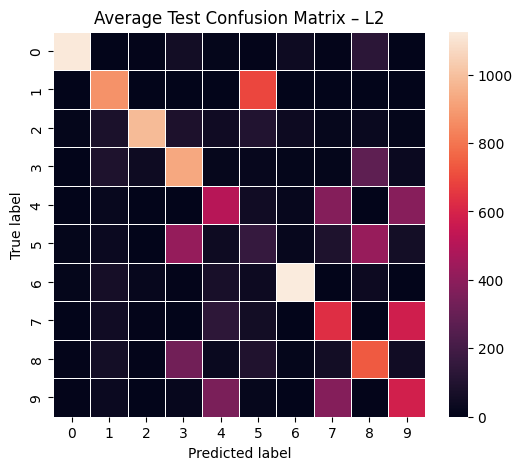

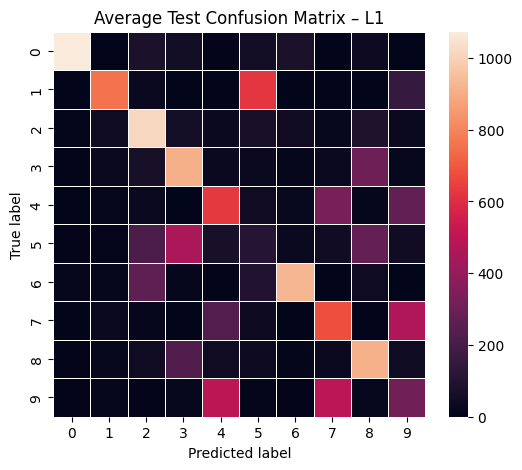

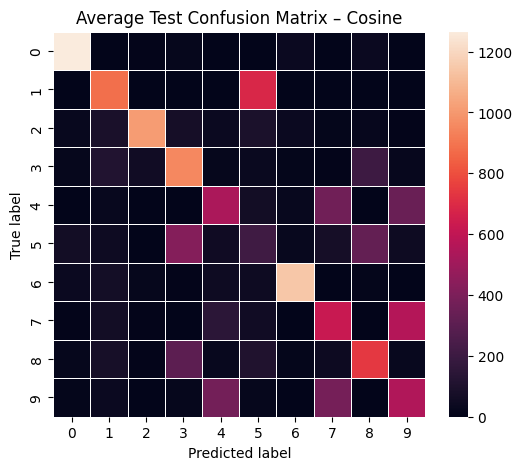

In [8]:

# ------------------------------------------------------------
# Visualisation: average confusion matrices
# ------------------------------------------------------------
avg_train_cms = {m: np.mean(cms, axis=0) for m, cms in train_cms.items()}
avg_test_cms  = {m: np.mean(cms, axis=0) for m, cms in test_cms.items()}

for m_name in metrics.values():
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(avg_test_cms[m_name], annot=False, fmt="d", linewidths=.5, ax=ax)
    ax.set_title(f"Average Test Confusion Matrix – {m_name}")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()



### Conclusions

To evaluate the clustering quality, we performed 5-fold cross-validation with an 80/20 train-test split, assigning cluster labels to digits based on majority voting within each cluster. The test evaluation was done using a 1-Nearest Neighbor (1-NN) approach, where each test sample was classified according to the closest training instance’s assigned cluster.

The results demonstrated that the Cosine distance metric yielded the highest accuracy, achieving an average test accuracy of approximately 56.51%, outperforming both Euclidean and Manhattan distances. This outcome aligns with theoretical expectations, as cosine similarity often performs better in high-dimensional spaces due to its focus on orientation rather than magnitude.

Overall, our findings suggest the following key points:

* Dimensionality reduction with PCA significantly contributes to the stability and interpretability of the clustering process.

* Cosine distance is particularly effective in the context of image data represented in high-dimensional spaces.

* Despite being an unsupervised method, k-means clustering can uncover meaningful structure in labeled datasets like MNIST when paired with appropriate preprocessing and evaluation techniques.